# 04 PyTorch Convolutional neural networks

![Conv net](https://miro.medium.com/max/1200/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

The fundamental difference between a densely connected layer and a convolution
layer is this: Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns—in the case of images, patterns found in small 2D windows of the inputs.

![local features](https://media.geeksforgeeks.org/wp-content/uploads/20211129095034/Importantfeaturesoftheimage.png)

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation-invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data-efficient when processing images (because the visual world is fundamentally translation-invariant): they need fewer training samples to learn representations that have generalization power.
- They can learn **spatial hierarchies of patterns**. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical.

![Spatial hierarchies](https://i.sstatic.net/bN2iA.png)

## Convolution basics

Convolutions operate over tensors called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray).

Since convolutional layers can recieve matrices as input, we can leave the input images' shape as is, and just perform normalization of its values.

The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

Convolutions are defined by two key parameters:

- Size of the patches extracted from the inputs: These are typically 3 × 3 or 5 × 5.
- Depth of the output feature map: This is the number of filters computed by the convolution.

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the
input feature map, stopping at every possible location, and extracting the patch of surrounding features.

![Strides](https://d2l.ai/_images/conv-pad.svg)

### Padding

Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile.

In Conv2D layers, padding is configurable via the padding argument, which takes two values:
* **valid**, which means no padding (only valid window locations will be used)
* **same**, which means "pad in such a way as to have an output with the same width and height as the input.” The padding argument defaults to "valid".

![Padding](https://programmathically.com/wp-content/uploads/2021/12/Screenshot-2021-12-03-at-10.33.11-1024x774.png)

### Strides

The other factor that can influence output size is the notion of strides. Our description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous.

But the distance between two successive windows is a parameter of the convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1.

Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). **Strided convolutions are rarely used in classification models.**

### Max-pooling

Max pooling consists of extracting windows from the input feature maps and
outputting the max value of each channel.

It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation.

A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2.

![Pooling](https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/llustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png)

### Visualizing CNNs

The [CNN Explainer](https://poloclub.github.io/cnn-explainer/) is an interactive, web-based tool designed to help us understand how Convolutional Neural Networks (CNNs) work.

It provides a visual, hands-on experience by:

* Visualizing the Network: It displays a complete CNN architecture (Tiny VGG) and allows you to see the data flow through each layer.
* Explaining Layers: It breaks down the function of each component, such as convolutional layers, ReLU activation, pooling layers, and the final classification (softmax) layer.
* Allowing Interaction: Users can hover over and click on different parts of the network to see details, such as activation maps and the specific operations being performed.

Supporting Custom Input: You can upload your own images to see how the network processes and classifies them in real-time in your browser.

![TinyVGG architecture, as setup by CNN explainer website](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-cnn-explainer-model.png)


## Basic imports

In [ ]:
!pip install torchmetrics > /dev/null

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


## Getting a dataset

![example image of FashionMNIST](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-fashion-mnist-slide.png)

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

class_names = train_data.classes

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.1MB/s]


### Visualizing our data

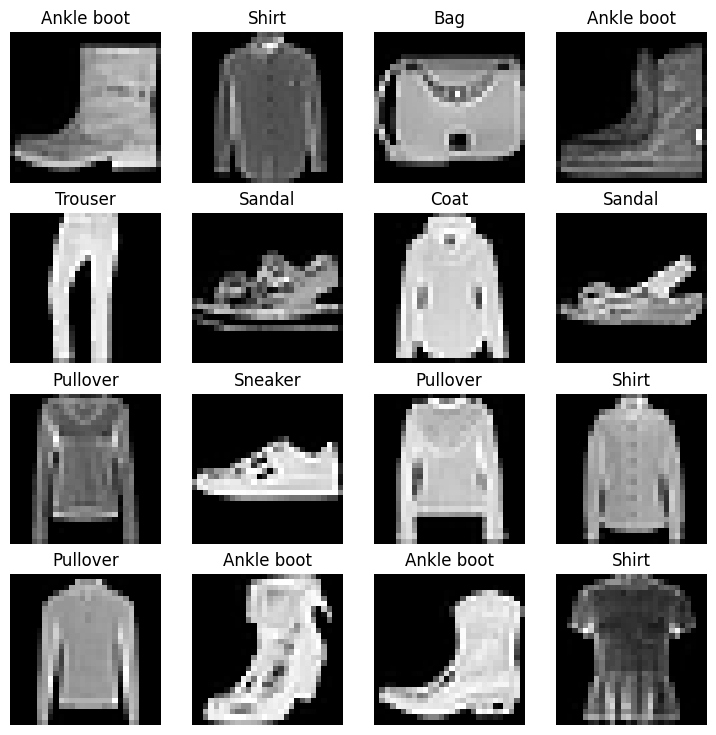

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## Prepare DataLoader


In [ ]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a89740df410>, <torch.utils.data.dataloader.DataLoader object at 0x7a897647f470>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## Building a Convolutional Neural Network (CNN)

It's time to create a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN or ConvNet).

CNN's are known for their capabilities to find patterns in visual data.

And since we're dealing with visual data, let's see if using a CNN model can improve upon our baseline.

The CNN model we're going to be using is known as TinyVGG from the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website.

![TinyVGG architecture, as setup by CNN explainer website](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-cnn-explainer-model.png)

It follows the typical structure of a convolutional neural network:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

Where the contents of `[Convolutional layer -> activation layer -> pooling layer]` can be upscaled and repeated multiple times, depending on requirements.

To do so, we'll leverage the [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers from `torch.nn`.




### Stepping through `nn.Conv2d()`

We could start using our model above and see what happens but let's first step through the two new layers we've added:
* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

> **Question:** What does the "2d" in `nn.Conv2d()` stand for?
>
> The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.
>
> For other dimensional data (such as 1D for text or 3D for 3D objects) there's also `nn.Conv1d()` and `nn.Conv3d()`.

To test the layers out, let's create some toy data just like the data used on CNN Explainer.

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing

print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


Let's create an example `nn.Conv2d()` with various parameters:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*

In [ ]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding="valid") # also try using "valid" or "same" here

# Pass the data through the convolutional layer
output = conv_layer(test_image)

print(f"Input image size:\n{test_image.shape}\n")
print(f"Shape after passing through the convolutional layer:\n{output.shape}")

Input image size:
torch.Size([3, 64, 64])

Shape after passing through the convolutional layer:
torch.Size([10, 62, 62])


Hmm, notice what happens to our shape (the same shape as the first layer of TinyVGG on [CNN Explainer](https://poloclub.github.io/cnn-explainer/)), we get different channel sizes as well as different pixel sizes.

What if we changed the values of `conv_layer`?

In [ ]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image).shape

torch.Size([10, 30, 30])

Woah, we get another shape change.

Now our image is of shape `[1, 10, 30, 30]` (it will be different if you use different values) or `[batch_size=1, color_channels=10, height=30, width=30]`.

What's going on here?

Behind the scenes, our `nn.Conv2d()` is compressing the information stored in the image.

It does this by performing operations on the input (our test image) against its internal parameters.

The goal of this is similar to all of the other neural networks we've been building.

Data goes in and the layers try to update their internal parameters (patterns) to lower the loss function thanks to some help of the optimizer.

The only difference is *how* the different layers calculate their parameter updates or in PyTorch terms, the operation present in the layer `forward()` method.

If we check out our `conv_layer_2.state_dict()` we'll find a similar weight and bias setup as we've seen before.

In [ ]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())

OrderedDict({'weight': tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],


Look at that! A bunch of random numbers for a weight and bias tensor.

The shapes of these are manipulated by the inputs we passed to `nn.Conv2d()` when we set it up.

Let's check them out.

In [ ]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


> **Question:** What should we set the parameters of our `nn.Conv2d()` layers?
>
> That's a good one. But similar to many other things in machine learning, the values of these aren't set in stone (and recall, because these values are ones we can set ourselves, they're referred to as "**hyperparameters**").
>
> The best way to find out is to try out different values and see how they effect your model's performance.
>
> Or even better, find a working example on a problem similar to yours (like we've done with TinyVGG) and copy it.

We're working with a different of layer here to what we've seen before.

But the premise remains the same: start with random numbers and update them to better represent the data.

### Stepping through `nn.MaxPool2d()`

Now let's check out what happens when we move data through `nn.MaxPool2d()`.

In [ ]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


Notice the change in the shapes of what's happening in and out of a `nn.MaxPool2d()` layer.

The `kernel_size` of the `nn.MaxPool2d()` layer will affect the size of the output shape.

In our case, the shape halves from a `62x62` image to `31x31` image.

Let's see this work with a smaller tensor.

In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


Notice the final two dimensions between `random_tensor` and `max_pool_tensor`, they go from `[2, 2]` to `[1, 1]`.

In essence, they get halved.

And the change would be different for different values of `kernel_size` for `nn.MaxPool2d()`.

Also notice the value leftover in `max_pool_tensor` is the **maximum** value from `random_tensor`.

What's happening here?

This is another important piece of the puzzle of neural networks.

Essentially, **every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being *smaller* in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to *compress* information.

![each layer of a neural network compresses the original input data into a smaller representation that is (hopefully) capable of making predictions on future input data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv-net-as-compression.png)

This means, that from the point of view of a neural network, intelligence is compression.

This is the idea of the use of a `nn.MaxPool2d()` layer: take the maximum value from a portion of a tensor and disregard the rest.

In essence, lowering the dimensionality of a tensor whilst still retaining a (hopefully) significant portion of the information.

It is the same story for a `nn.Conv2d()` layer.

Except instead of just taking the maximum, the `nn.Conv2d()` performs a convolutional operation on the data (see this in action on the [CNN Explainer webpage](https://poloclub.github.io/cnn-explainer/)).

> **Exercise:** What do you think the [`nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) layer does? Try making a random tensor like we did above and passing it through. Check the input and output shapes as well as the input and output values.

> **Extra-curriculum:** Lookup "most common convolutional neural networks", what architectures do you find? Are any of them contained within the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) library? What do you think you could do with these?

### Defining a model

After understanding the basics of convolutions, we can define a model to train on our images.

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    metric = Accuracy(task="multiclass", num_classes=10).to(device)

    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        metric.update(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc = metric.compute()
    metric.reset()
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    test_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    model.to(device)
    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_metric.update(test_pred, y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc = test_metric.compute()
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelCNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
cnn_model = FashionMNISTModelCNN(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
cnn_model

FashionMNISTModelCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

The 7*7 comes from the spatial dimensions (Height x Width) of your data after it has passed through all the convolutional and pooling layers (block_1 and block_2).

The nn.Flatten() layer's job is to take a multi-dimensional tensor and squash it into a 1D vector so it can be fed into a standard nn.Linear (fully connected) layer.

Here’s a step-by-step trace of how the shape changes for FashionMNIST images, which are $28 \times 28$ pixels.

* Input: [batch_size, 1, 28, 28]
* Pass through block_1:
    * nn.Conv2d(..., padding=1): A $3 \times 3$ kernel with padding=1 is "same" padding. It does not change the $28 \times 28$ size.
    * nn.ReLU(): Does not change the shape.
    * nn.Conv2d(..., padding=1): Again, "same" padding. Shape remains $28 \times 28$.
    * nn.ReLU(): Does not change the shape.
    * nn.MaxPool2d(kernel_size=2, stride=2): This layer halves the height and width.
    * Output of block_1 Shape: [batch_size, hidden_units, 14, 14]
* Pass through block_2:
    * Input to block_2 is [batch_size, hidden_units, 14, 14].
    * nn.Conv2d(..., padding=1): "Same" padding. Shape remains $14 \times 14$.
    * nn.ReLU(): Does not change the shape.
    * nn.Conv2d(..., padding=1): "Same" padding. Shape remains $14 \times 14$.
    * nn.ReLU(): Does not change the shape.
    * nn.MaxPool2d(2): This layer (with kernel size 2 and default stride 2) halves the height and width again.
    * Output of block_2 Shape: [batch_size, hidden_units, 7, 7]
* Pass to self.classifier:
    * nn.Flatten(): This is the key. It takes the tensor from block_2 (shape [batch_size, hidden_units, 7, 7]) and "flattens" it. It keeps the batch dimension but multiplies all other dimensions together.
    * Output of Flatten Shape: [batch_size, hidden_units * 7 * 7]
    * nn.Linear(in_features=..., out_features=...): This layer requires a 1D vector (per item in the batch) as input. Its in_features must match the size of the vector it just received from nn.Flatten().
    * Therefore, in_features must be hidden_units * 7 * 7.


There is a standard formula to calculate the output height and width for both convolutional and pooling layers.The formula for the output dimension (Height or Width) is:$$\text{Output} = \lfloor \frac{I - K + 2P}{S} \rfloor + 1$$

Where:
* $I$ = Input dimension (e.g., input height $H_{in}$ or width $W_{in}$)
* $K$ = Kernel size
* $P$ = Padding
* $S$ = Stride

Applying the Formula to the model, let's trace the width (the calculation is identical for height) starting from the $28 \times 28$ input.

Block 1

* First nn.Conv2d:
    * Input ($I$) = 28
    * Kernel ($K$) = 3
    * Padding ($P$) = 1
    * Stride ($S$) = 1
    * Output = $\lfloor \frac{28 - 3 + 2(1)}{1} \rfloor + 1 = \lfloor \frac{27}{1} \rfloor + 1 = 27 + 1 = \mathbf{28}$
* Second nn.Conv2d: (Input is 28 from the previous layer)
    * Input ($I$) = 28
    * Kernel ($K$) = 3
    * Padding ($P$) = 1
    * Stride ($S$) = 1
    * Output = $\lfloor \frac{28 - 3 + 2(1)}{1} \rfloor + 1 = \lfloor \frac{27}{1} \rfloor + 1 = 27 + 1 = \mathbf{28}$
* First nn.MaxPool2d: (Input is 28 from the previous layer)
    * Input ($I$) = 28
    * Kernel ($K$) = 2
    * Padding ($P$) = 0 (default for MaxPool2d)
    * Stride ($S$) = 2
    * Output = $\lfloor \frac{28 - 2 + 2(0)}{2} \rfloor + 1 = \lfloor \frac{26}{2} \rfloor + 1 = 13 + 1 = \mathbf{14}$
* Output shape after block_1 is $14 \times 14$.

Block 2

* Third nn.Conv2d: (Input is 14 from block_1)
    * Input ($I$) = 14
    * Kernel ($K$) = 3
    * Padding ($P$) = 1
    * Stride ($S$) = 1
    * Output = $\lfloor \frac{14 - 3 + 2(1)}{1} \rfloor + 1 = \lfloor \frac{13}{1} \rfloor + 1 = 13 + 1 = \mathbf{14}$
* Fourth nn.Conv2d: (Input is 14 from the previous layer)
    * Input ($I$) = 14
    * Kernel ($K$) = 3
    * Padding ($P$) = 1
    * Stride ($S$) = 1
    * Output = $\lfloor \frac{14 - 3 + 2(1)}{1} \rfloor + 1 = \lfloor \frac{13}{1} \rfloor + 1 = 13 + 1 = \mathbf{14}$
* Second nn.MaxPool2d: (Input is 14 from the previous layer)
    * Input ($I$) = 14
    * Kernel ($K$) = 2
    * Padding ($P$) = 0 (default)
    * Stride ($S$) = 2
    * Output = $\lfloor \frac{14 - 2 + 2(0)}{2} \rfloor + 1 = \lfloor \frac{12}{2} \rfloor + 1 = 6 + 1 = \mathbf{7}$
* Final output shape after block_2 is $7 \times 7$.

This $7 \times 7$ is then flattened (along with the hidden_units channels) to create the hidden_units * 7 * 7 vector for the linear layer.

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_model.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    metric = Accuracy(task="multiclass", num_classes=10).to(device)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            metric.update(y_pred, y)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc = metric.compute()

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

### Training and testing the model

We'll use our `train_step()` and `test_step()` functions we created before.

We'll also measure the time to compare it to our other models.

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_cnn_model = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=cnn_model,
        loss_fn=loss_fn,
        device=device
    )

train_time_end_cnn_model = timer()
total_train_time_cnn_model = print_train_time(start=train_time_start_cnn_model,
                                           end=train_time_end_cnn_model,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59239 | Train accuracy: 0.78%
Test loss: 0.39700 | Test accuracy: 0.86%

Epoch: 1
---------
Train loss: 0.35993 | Train accuracy: 0.87%
Test loss: 0.35415 | Test accuracy: 0.87%

Epoch: 2
---------
Train loss: 0.32512 | Train accuracy: 0.88%
Test loss: 0.32398 | Test accuracy: 0.88%

Train time on cuda: 37.410 seconds


Woah! Looks like the convolutional and max pooling layers helped improve performance a little.

Let's evaluate `model_2`'s results with our `eval_model()` function.

In [ ]:
# Get cnn_model results
cnn_model_results = eval_model(
    model=cnn_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
)
cnn_model_results

{'model_name': 'FashionMNISTModelCNN',
 'model_loss': 0.32398495078086853,
 'model_acc': tensor(0.8818, device='cuda:0')}

## Make and evaluate random predictions with best model

Alright, we've compared our models to each other, let's further evaluate our best performing model, `model_2`.

To do so, let's create a function `make_predictions()` where we can pass the model and some data for it to predict on.

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


And now we can use our `make_predictions()` function to predict on `test_samples`.

In [ ]:
# Make predictions on test samples with the model
pred_probs= make_predictions(model=cnn_model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[8.5046e-08, 3.8998e-09, 6.1873e-08, 3.4051e-08, 6.6209e-09, 9.9999e-01,
         7.5039e-09, 2.9603e-06, 6.9610e-06, 2.6245e-06],
        [1.9892e-02, 9.2752e-01, 3.9098e-04, 4.5588e-02, 2.2420e-03, 5.5639e-05,
         4.1612e-03, 8.1322e-05, 5.9306e-05, 1.4615e-05]])

Excellent!

And now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

Now our predicted classes are in the same format as our test labels, we can compare.

Since we're dealing with image data, let's stay true to the data explorer's motto.

"Visualize, visualize, visualize!"

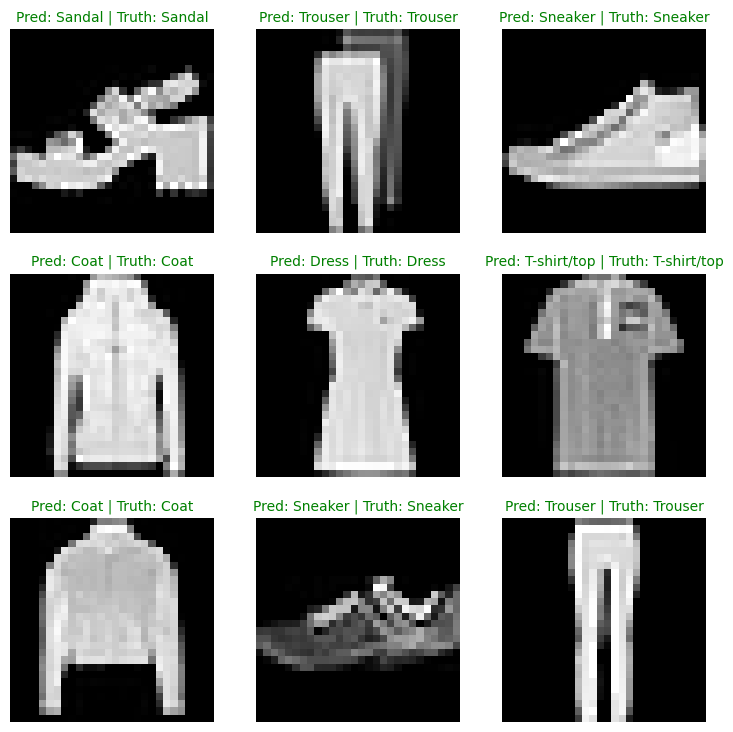

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Well, well, well, doesn't that look good!

Not bad for a couple dozen lines of PyTorch code!

## Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predictions and true labels.

To make a confusion matrix, we'll go through three steps:
1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Let's start by making predictions with our trained model.

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
cnn_model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = cnn_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

Wonderful!

Now we've got predictions, let's go through steps 2 & 3:
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

First we'll need to make sure we've got `torchmetrics` and `mlxtend` installed (these two libraries will help us make and visualize a confusion matrix).

> **Note:** If you're using Google Colab, the default version of `mlxtend` installed is 0.14.0 (as of March 2022), however, for the parameters of the `plot_confusion_matrix()` function we'd like use, we need 0.19.0 or higher.

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


To plot the confusion matrix, we need to make sure we've got and [`mlxtend`](http://rasbt.github.io/mlxtend/) version of 0.19.0 or higher.

In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


`torchmetrics` and `mlxtend` installed, let's make a confusion matrix!

First we'll create a `torchmetrics.ConfusionMatrix` instance telling it how many classes we're dealing with by setting `num_classes=len(class_names)`.

Then we'll create a confusion matrix (in tensor format) by passing our instance our model's predictions (`preds=y_pred_tensor`) and targets (`target=test_data.targets`).

Finally we can plot our confusion matrix using the `plot_confusion_matrix()` function from `mlxtend.plotting`.

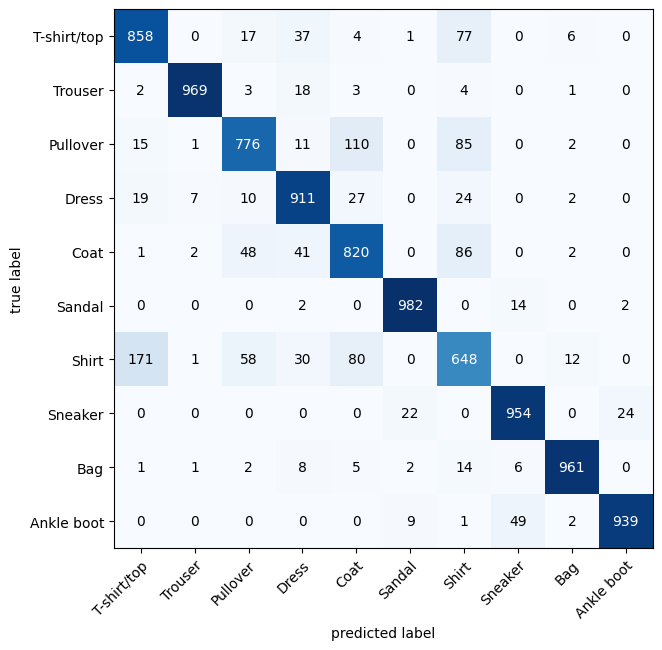

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

Woah! Doesn't that look good?

We can see our model does fairly well since most of the dark squares are down the diagonal from top left to bottom right (and ideal model will have only values in these squares and 0 everywhere else).

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

This kind of information is often more helpful than a single accuracy metric because it tells use *where* a model is getting things wrong.

It also hints at *why* the model may be getting certain things wrong.

It's understandable the model sometimes predicts "Shirt" for images labelled "T-shirt/top".

We can use this kind of information to further inspect our models and data to see how it could be improved.

## Save and load model

Let's finish this section off by saving and loading in our best performing model.

We can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `cnn_model`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "pytorch_convolutional_layers.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=cnn_model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_convolutional_layers.pth


Now we've got a saved model `state_dict()` we can load it back in using a combination of `load_state_dict()` and `torch.load()`.

Since we're using `load_state_dict()`, we'll need to create a new instance of `FashionMNISTModelV2()` with the same input parameters as our saved model `state_dict()`.

In [ ]:
# Create a new instance of FashionMNISTModelCNN (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_cnn_model = FashionMNISTModelCNN(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_cnn_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_cnn_model.to(device)

And now we've got a loaded model we can evaluate it with `eval_model()` to make sure its parameters work similarly to `model_2` prior to saving.

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_cnn_model_results = eval_model(
    model=loaded_cnn_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn
)

loaded_cnn_model_results

{'model_name': 'FashionMNISTModelCNN',
 'model_loss': 0.32398495078086853,
 'model_acc': tensor(0.8818, device='cuda:0')}

Do these results look the same as `model_2_results`?

In [ ]:
cnn_model_results

{'model_name': 'FashionMNISTModelCNN',
 'model_loss': 0.32398495078086853,
 'model_acc': tensor(0.8818, device='cuda:0')}

We can find out if two tensors are close to each other using `torch.isclose()` and passing in a tolerance level of closeness via the parameters `atol` (absolute tolerance) and `rtol` (relative tolerance).

If our model's results are close, the output of `torch.isclose()` should be true.

In [ ]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(cnn_model_results["model_loss"]),
              torch.tensor(loaded_cnn_model_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)

## Challenge

Create a model using the [Alexnet architecture](https://en.wikipedia.org/wiki/AlexNet)(shown below), and train the model using the CIFAR10 dataset.

![Alexnet](https://raw.githubusercontent.com/octavio-navarro/DL_Data_sets/main/images/Alexnet_architecture.png)

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(size=(256, 256)),
  transforms.ToTensor()]
    )


# Setup training data
train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=transform,
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=transform,
    target_transform=None
)

class_names = train_data.classes

In [ ]:
class AlexNetCIFAR10(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape,
                      out_channels=96,
                      kernel_size=11, # how big is the square that's going over the image?
                      stride=4,
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96,
                      out_channels=256,
                      kernel_size=5,
                      stride=1, # default
                      padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256,
                      out_channels=384,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384,
                      out_channels=384,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=384,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256*6*6,
                      out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096,
                      out_features=4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=4096,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
alexnet_model = AlexNetCIFAR10(input_shape=3,
    output_shape=len(class_names)).to(device)
alexnet_model

AlexNetCIFAR10(
  (block_1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)


In [ ]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fcf84166c90>, <torch.utils.data.dataloader.DataLoader object at 0x7fcf84167bf0>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# train loop

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    metric = Accuracy(task="multiclass", num_classes=10).to(device)

    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to avalilable device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        metric.update(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc = metric.compute()
    metric.reset()
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {(train_acc*100):.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    test_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    model.to(device)
    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_metric.update(test_pred, y)

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc = test_metric.compute()
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {(test_acc*100):.2f}%\n")

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=alexnet_model.parameters(), lr=0.1)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    loss, acc = 0, 0
    metric = Accuracy(task="multiclass", num_classes=10).to(device)

    model.to(device)
    model.eval()

    Xs = []
    ys = []
    y_preds = []

    with torch.inference_mode():
        for X, y in data_loader:

            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            metric.update(y_pred, y)

            Xs.append(X)
            ys.append(y)
            y_preds.append(y_pred)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc = metric.compute()

    # taking out the tensors from the batches
    Xs = torch.cat(Xs, dim=0)
    ys = torch.cat(ys, dim=0)
    y_preds = torch.cat(y_preds, dim=0)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc,
            "Xs": Xs,
            "ys": ys,
            "y_preds": y_preds}

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_alexnet_model = timer()

# Train and test model
epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=alexnet_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=alexnet_model,
        loss_fn=loss_fn,
        device=device
    )

train_time_end_alexnet_model = timer()
total_train_time_alexnet_model = print_train_time(start=train_time_start_alexnet_model,
                                           end=train_time_end_alexnet_model,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.28858 | Train accuracy: 11.72%
Test loss: 2.15378 | Test accuracy: 18.57%

Epoch: 1
---------
Train loss: 1.92514 | Train accuracy: 28.48%
Test loss: 1.65597 | Test accuracy: 39.30%

Epoch: 2
---------
Train loss: 1.48638 | Train accuracy: 46.41%
Test loss: 1.27249 | Test accuracy: 54.25%

Epoch: 3
---------
Train loss: 1.13947 | Train accuracy: 59.78%
Test loss: 1.16037 | Test accuracy: 58.77%

Epoch: 4
---------
Train loss: 0.87633 | Train accuracy: 69.32%
Test loss: 1.11441 | Test accuracy: 63.02%

Epoch: 5
---------
Train loss: 0.65359 | Train accuracy: 77.28%
Test loss: 0.90533 | Test accuracy: 70.64%

Epoch: 6
---------
Train loss: 0.46559 | Train accuracy: 83.68%
Test loss: 1.11350 | Test accuracy: 65.25%

Epoch: 7
---------
Train loss: 0.33131 | Train accuracy: 88.53%
Test loss: 0.97613 | Test accuracy: 72.54%

Epoch: 8
---------
Train loss: 0.22993 | Train accuracy: 92.18%
Test loss: 1.17842 | Test accuracy: 69.62%

Epoch: 9
---------
Train los